In [17]:
import psycopg2 # type: ignore
import matplotlib.pyplot as plt # type: ignore
import pandas as pd # type: ignore
from tqdm import tqdm # type: ignore
import numpy as np # type: ignore
import pandas as pd # type: ignore
import plotly.graph_objects as go # type: ignore
import yfinance as yf # type: ignore
import os
import warnings
warnings.filterwarnings("ignore")
os.chdir("../database")

In [18]:
# database initialization
list_ = ["2219.HK", "1093.HK", "6030.HK", "0291.HK", "9961.HK", "6690.HK", "2313.HK", "1928.HK", "0005.HK", "0384.HK",
         "1113.HK", "0981.HK", "0006.HK", "0011.HK", "0003.HK", "1109.HK", "9633.HK", "2899.HK", "1398.HK", "0939.HK",
         "0027.HK", "0823.HK", "0001.HK", "1088.HK", "0386.HK", "0016.HK", "3968.HK", "0002.HK", "0669.HK", "3988.HK",
         "1171.HK", "9868.HK", "2269.HK", "1810.HK", "0700.HK", "2382.HK", "2386.HK", "2318.HK", "0992.HK", "1024.HK",
         "9618.HK", "0883.HK", "0388.HK", "0175.HK", "0941.HK", "2628.HK", "1211.HK", "2388.HK", "9888.HK", "2020.HK", "9988.HK", "1299.HK"]
df = yf.download(list_, start='2018-01-01')
df['Close'].to_parquet("hk_price_close.parquet")
df['Open'].to_parquet("hk_price_open.parquet")

[*********************100%***********************]  52 of 52 completed


In [19]:
open = pd.read_parquet('hk_price_open.parquet')
close = pd.read_parquet('hk_price_close.parquet')

In [20]:
# functions
def get_demean_weighting(factor):
    df1 = factor.dropna(axis='columns', how='all').copy()
    demean = df1.sub(df1.mean(axis=1), axis=0)
    weighting = demean.div(demean.abs().sum(axis=1), axis=0)
    return weighting
def _reweighting_equal(weighting:pd.DataFrame):
    def equal_weight(row: pd.Series):
        count_larger_than_zero = (row != 0).sum()
        if count_larger_than_zero > 0:
            row = row.apply(lambda x: 1 / count_larger_than_zero if x > 0 else x)
        return row
    return weighting.apply(equal_weight, axis=1)
def intraday_shifted_input_signal_pct_output_plot(ln_, pct_calculating_profit, quantile=10, type_='cumsum'):
        
    time_length = len(ln_)
    quantile_column = [[None]*quantile]*time_length
    quantile_df = pd.DataFrame(quantile_column)
    for da in range(time_length):
        row = ln_.iloc[da, :]
        col = row.sort_values(ascending=False).index
        for i in range(0, quantile):
            quantile_df.iloc[da, i] = list(col[i*int(len(row)/quantile):(i+1)*int(len(row)/quantile)])

    # pct_close_w_corres = pct_calculating_profit[pct_calculating_profit.columns.intersection(ln_.columns)].shift(-2)
    holdings = []
    index = ln_.index
    quantiles = [None] * quantile
    for qt_iter in range(quantile):
        quantile_1 = quantile_df.iloc[:, qt_iter]
        if qt_iter == 0: holdings = quantile_1
        df_1 = ln_.copy()
        for i in range(len(quantile_1)):
            df_1.loc[index[i], ~df_1.columns.isin(quantile_1[i])] = 0
        weighting_1 = -_reweighting_equal(df_1)
        ret = pct_calculating_profit.loc[weighting_1.index[0]:] * weighting_1
        if type_ == "cumsum":
            quantiles[qt_iter] = ret.sum(axis=1).cumsum()
        else:
            quantiles[qt_iter] = (1 + ret.sum(axis=1)).cumprod() - 1
    quantilized_cumsum = pd.DataFrame(quantiles).T
    fig = go.Figure()
    for i in range(len(quantilized_cumsum.columns)):
        fig.add_trace(go.Scatter(
            x=quantilized_cumsum.index,
            y=quantilized_cumsum.iloc[:, i],
            name=f"{i} th quantile",
            mode="lines",
            # line=dict(color="orange"),
            yaxis="y1"
        ))
    fig.show()
    # quantilized_cumsum.iloc[:, :].plot(title="10 quantile cumsum distribution")
    return holdings

In [21]:
# momentum: ln(close_/open_)
time_ = "2020-01-01"; end_ = '2025-01-24'
open_ = open[time_:end_]
close_ = close[time_:end_]
ln_ = np.log(close_/open_).shift(1) # index: 使用的時間
pct_calculating_profit = close_/open_-1 # index: 當天收益
holdings = intraday_shifted_input_signal_pct_output_plot(ln_, pct_calculating_profit, quantile=10, type_='cumsum')

# Medium-length

In [13]:
# 2020-01-10: 2020-01-03 ~ 2020-01-10 的累積收益 => 
# 1. Momentum 用上禮拜開~收盤:
#   => 算出來的ln_會是index 對標產生的日期 => 對應下禮拜2020-01-13 ~ 2020-01-17 開盤到收盤的收益
#   => W-FRI 01-10 => W-MON 01-20 // W-FRI x W-MON.shift(-1)

In [14]:
def intraday_shifted_input_signal_pct_output_plot(ln_, pct_calculating_profit, quantile=10, type_='cumsum'):
        
    time_length = len(ln_)
    quantile_column = [[None]*quantile]*time_length
    quantile_df = pd.DataFrame(quantile_column)
    for da in range(time_length):
        row = ln_.iloc[da, :]
        col = row.sort_values(ascending=False).index
        for i in range(0, quantile):
            quantile_df.iloc[da, i] = list(col[i*int(len(row)/quantile):(i+1)*int(len(row)/quantile)])

    # pct_close_w_corres = pct_calculating_profit[pct_calculating_profit.columns.intersection(ln_.columns)].shift(-2)
    holdings = []
    index = ln_.index
    quantiles = [None] * quantile
    for qt_iter in range(quantile):
        quantile_1 = quantile_df.iloc[:, qt_iter]
        if qt_iter == 0: 
            holdings = quantile_1
            holdings.index = pct_calculating_profit.index0
        df_1 = ln_.copy()
        for i in range(len(quantile_1)):
            df_1.loc[index[i], ~df_1.columns.isin(quantile_1[i])] = 0
        weighting_1 = _reweighting_equal(df_1)
        ret = pct_calculating_profit.loc[weighting_1.index[0]:] * weighting_1
        if type_ == "cumsum":
            quantiles[qt_iter] = ret.sum(axis=1).cumsum()
        else:
            quantiles[qt_iter] = (1 + ret.sum(axis=1)).cumprod() - 1
    quantilized_cumsum = pd.DataFrame(quantiles).T
    fig = go.Figure()
    for i in range(len(quantilized_cumsum.columns)):
        fig.add_trace(go.Scatter(
            x=quantilized_cumsum.index,
            y=quantilized_cumsum.iloc[:, i],
            name=f"{i} th quantile",
            mode="lines",
            # line=dict(color="orange"),
            yaxis="y1"
        ))
    fig.show()
    # quantilized_cumsum.iloc[:, :].plot(title="10 quantile cumsum distribution")
    return holdings

# Monthly Swing HK

In [ ]:
# ln_ 取負號或是 weighting_ 取負號的效果不一樣，並且對weighting 取負號效果比較好

In [453]:
# momentum: ln(open_/close_.shift(1)) 如果要更保守，就li_.shift(1)
time_ = "2018-10-15"; end_ = '2025-01-24'
open_ = open[time_:end_]
close_ = close[time_:end_]
ln_ = np.log(open_/close_.shift(1)) # index: 使用的時間
pct_calculating_profit = close_/open_-1 # index: 當天收益
holdings = intraday_shifted_input_signal_pct_output_plot(ln_.shift(0), pct_calculating_profit.shift(0), quantile=10, type_='cumsum')

In [477]:
import numpy as np
import pandas as pd

def pearson_correlation(x, y):
    n = len(x)
    x_mean = sum(x) / n
    y_mean = sum(y) / n

    numerator = sum((x[i] - x_mean) * (y[i] - y_mean) for i in range(n))
    denominator = (sum((x[i] - x_mean) ** 2 for i in range(n)) * sum((y[i] - y_mean) ** 2 for i in range(n))) ** 0.5

    return numerator / denominator if denominator != 0 else 0

def spearman_correlation(x, y):
    n = len(x)
    x_ranks = pd.Series(x).rank().tolist()
    y_ranks = pd.Series(y).rank().tolist()
    d_squared = sum((x_ranks[i] - y_ranks[i]) ** 2 for i in range(n))
    rho = 1 - (6 * d_squared) / (n * (n ** 2 - 1))

Pearson Correlation: nan
Spearman Correlation: nan


Mean correlation coefficient: -0.03439846560900018


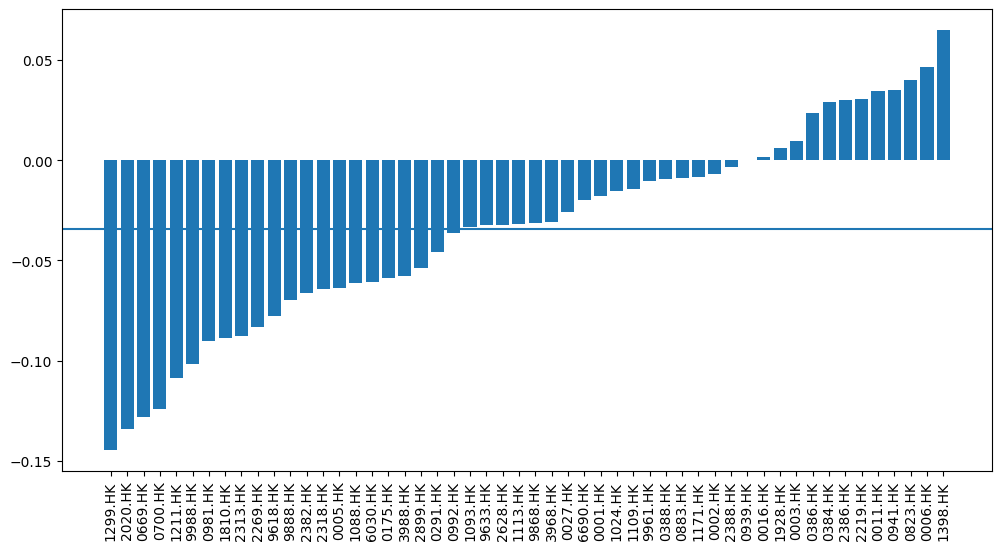

In [22]:
ind_corrcoef = pd.Series()
ln_cols = list(ln_.columns)
ln_array = np.array(ln_.iloc[1:, :]).T
pct_array = np.array(pct_calculating_profit.iloc[1:, :]).T
for i in range(ln_array.shape[0]):
    valid_mask = ~np.isnan(ln_array[i]) & ~np.isnan(pct_array[i])  # Boolean mask for valid data
    if valid_mask.any():  # Only compute correlation if there's at least one valid data point
        corr = np.corrcoef(ln_array[i][valid_mask], pct_array[i][valid_mask])[0, 1]
        ind_corrcoef[ln_cols[i]] = corr
    else:
        ind_corrcoef[ln_cols[i]] = np.nan  # If no valid data, append NaN

# Plot and calculate the mean of non-NaN correlation coefficients
ind_corrcoef = ind_corrcoef.sort_values(ascending=True)
mean_corrcoef = np.nanmean(ind_corrcoef)  # np.nanmean automatically ignores NaNs
plt.figure(figsize=(12, 6))
plt.bar(ind_corrcoef.index, ind_corrcoef)
plt.axhline(mean_corrcoef)
plt.xticks(rotation=90)
print("Mean correlation coefficient:", mean_corrcoef)


(<BarContainer object of 52 artists>, np.float64(-0.06399692743351883))

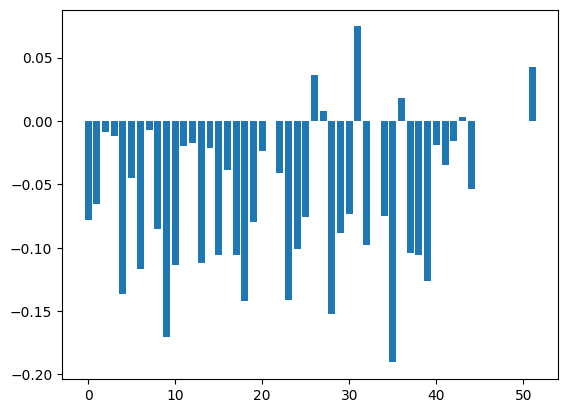

In [375]:
ln_array = np.array(ln_.iloc[1:, :]).T
pct_array = np.array(pct_calculating_profit.iloc[1:, :]).T
ind_corrcoef = [np.corrcoef(ln_array[i], pct_array[i])[0, 1] for i in range(ln_array.shape[0])]
plt.bar(np.arange(len(ind_corrcoef)), ind_corrcoef), np.mean(np.array(ind_corrcoef)[~np.isnan(ind_corrcoef)])